Poisson Regression
===========

Use a generalized linear model to perform a regression on some dummy data as a test to make sure I can actually use `pymc3` for my work, if I need to.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
from scipy import optimize

import pymc3 as pm
import theano as thno
import theano.tensor as T

import seaborn as sns

In [3]:
def plot_traces(traces, varnames=None):
    nrows = len(traces.varnames)
    if varnames is not None:
        nrows = len(varnames)
    
    ax = pm.traceplot(traces, varnames=varnames,
                      figsize=(12, nrows * 1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(traces, varnames=varnames).iterrows()})
    for i, mn in enumerate(pm.df_summary(traces, varnames=varnames)['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points', rotation=90,
                          va='bottom', fontsize='large', color='#AA0022')

In [4]:
import re

def strip_derived_rvs(rvs):
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

We're going to simulate data, where we are making an assumption that sneezing increases with antihistamine use and alcohol consumption. We'll record the number of sneezes per day, and alcohol use is kept as a boolean value.

In [5]:
# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q),
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})
df.head()

,alcohol,nomeds,nsneeze
0,False,False,0
1,False,False,1
2,False,False,0
3,False,False,1
4,False,False,0


In [16]:
df.groupby(['alcohol', 'nomeds']).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     1.019   5.945
True      2.974  36.016

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


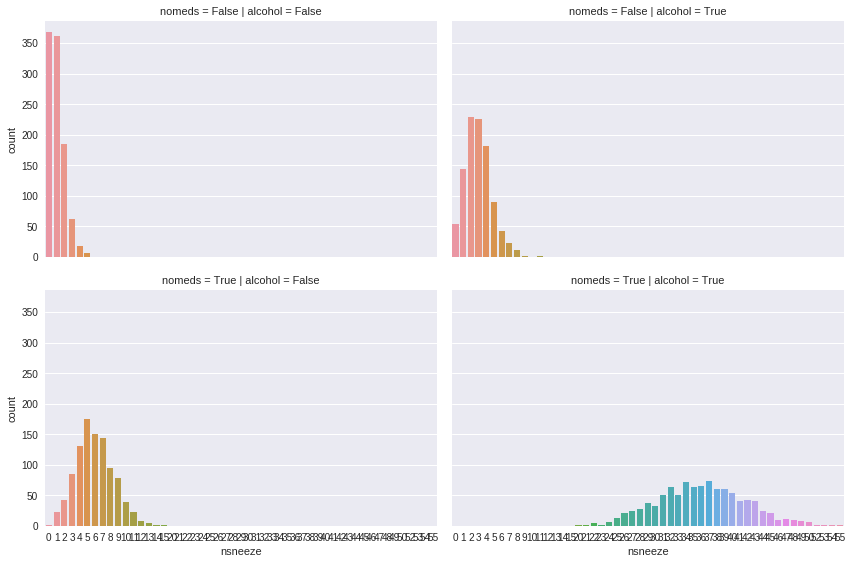

In [7]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol',
                   data=df, kind='count', size=4, aspect=1.5)

Simple poisson regression model with interactions of terms:
$$ \theta = \exp(\beta X)$$
$$ Y_{\rm{sneeze count}} \rm{Poisson}(\theta)$$

In [8]:
formula = 'nsneeze ~ alcohol * nomeds'

In [10]:
# build design matrices...?

mx_en, mx_ex = pt.dmatrices(formula, df, return_type='dataframe',
                            NA_action='raise')
pd.concat([mx_ex.head(3), mx_ex.tail(3)])

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


Now, we can actually create the model that we will use. We'll first create and fit the model, then sample from it.

In [11]:
with pm.Model() as model:
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_alcohol', mu=0, sd=10)
    b2 = pm.Normal('b2_nomeds', mu=0, sd=10)
    b3 = pm.Normal('b3_alcohol_nomeds', mu=0, sd=10)
    
    theta = (b0
             + b1 * mx_ex['alcohol[T.True]']
             + b2 * mx_ex['nomeds[T.True]']
             + b3 * mx_ex['alcohol[T.True]:nomeds[T.True]'])
    y = pm.Poisson('y',
                   mu=pm.math.exp(theta),
                   observed=mx_en['nsneeze'].values)

In [12]:
with model:
    trace = pm.sample(2000, tune=1000, njobs=8)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -8,742.5: 100%|██████████| 200000/200000 [01:01<00:00, 3267.66it/s]
Finished [100%]: Average ELBO = -8,742.4
100%|██████████| 2000/2000 [02:57<00:00, 34.61it/s]


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


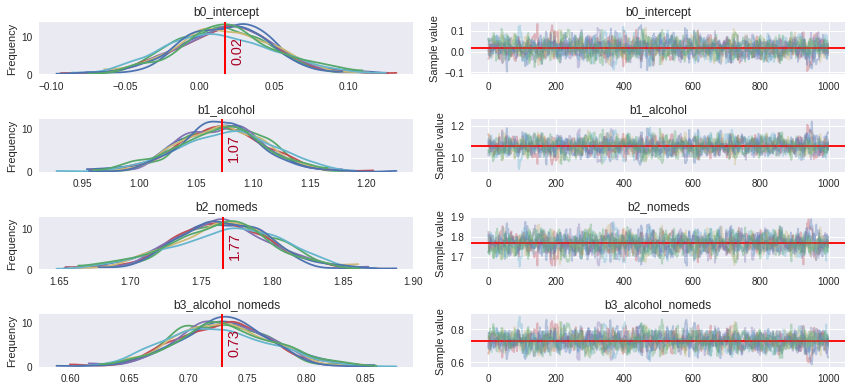

In [13]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=rvs)

In [17]:
results = np.exp(pm.df_summary(
    trace, varnames=rvs)[['mean','hpd_2.5','hpd_97.5']])
results

,mean,hpd_2.5,hpd_97.5
b0_intercept,1.017218,0.954881,1.083426
b1_alcohol,2.922961,2.711966,3.138807
b2_nomeds,5.844862,5.470132,6.281827
b3_alcohol_nomeds,2.072286,1.909576,2.229025


These results match up with what we had used to generate our test data, which is a good sign. We have a relatively low baseline, moderate effect from drinking, a larger effect on not using an antihistamine, and a small effect from doing both. All are positive, so any of those changes (drinking or not taking medicine) increase the expected number of sneezes.

We drinking and not taking medicine, we expect the sneeze count to be all of the factors multiplied:

In [20]:
results['mean'].cumprod().iloc[-1]

36.013155481058945

This value matches what we started with.

Alternate method
------------------

Instead of setting up all of the scaffolding ourselves, we can used the generalized linear model provided by `pymc3` to set those up for us.

In [23]:
with pm.Model() as model_glm:
    pm.glm.glm(formula, df, family=pm.glm.families.Poisson())

In [24]:
with model_glm:
    trace_glm = pm.sample(4000, tune=2000, njobs=8)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -8,788.5: 100%|██████████| 200000/200000 [01:00<00:00, 3282.68it/s]
Finished [100%]: Average ELBO = -8,788.5
100%|██████████| 4000/4000 [04:13<00:00, 15.79it/s]


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


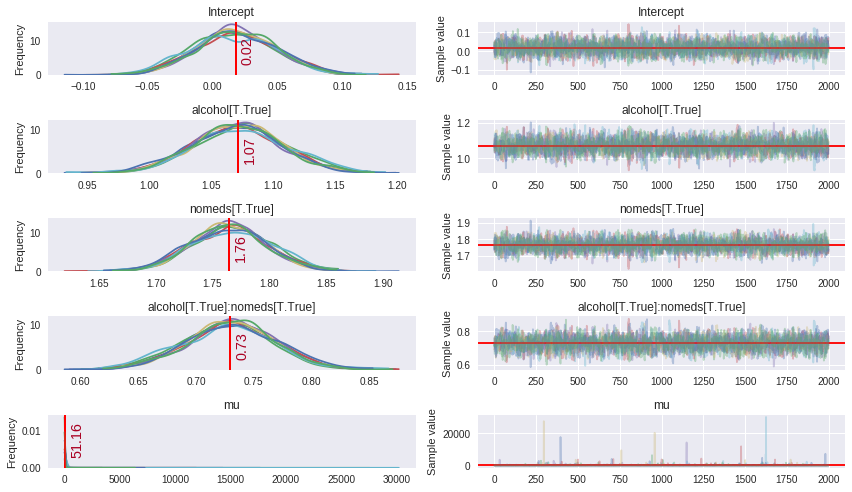

In [25]:
rvs_glm = [rv.name for rv in
           strip_derived_rvs(model_glm.unobserved_RVs)]
plot_traces(trace_glm, varnames=rvs_glm)

In [26]:
results_glm = np.exp(pm.df_summary(
    trace_glm, varnames=rvs_glm)[['mean','hpd_2.5','hpd_97.5']])
results_glm

,mean,hpd_2.5,hpd_97.5
Intercept,1.018073e+00,0.958452,1.081597e+00
alcohol[T.True],2.919972e+00,2.717833,3.132186e+00
nomeds[T.True],5.840463e+00,5.467796,6.236813e+00
alcohol[T.True]:nomeds[T.True],2.074340e+00,1.916156,2.231959e+00
mu,1.654345e+22,1.001239,1.160700e+52


In [28]:
np.percentile(trace_glm['mu'], [25,50,75])

array([  4.06099275,   9.86170039,  23.54959642])

In [29]:
df['nsneeze'].mean()

11.4885